# Customer Retention Strategy for Model Fitness Gyms

This project aims to analyze customer retention and churn patterns at Model Fitness branches across the USA. Our objective is to conduct an in-depth examination of churned customers, identify key trends, and understand the primary reasons behind membership cancellations.

The insights from this analysis will guide the development of a comprehensive customer retention strategy designed to enhance member loyalty and address the increasing churn rates, which have emerged as a significant business concern. This strategy will reinforce our commitment to improving member retention and overall customer satisfaction.

In [1]:
# General libraries
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

# Sklearn libraries for algorithms, metrics, and clustering
from sklearn.cluster import KMeans
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
)

# Display settings
pd.set_option("display.max_columns", None)

# Chart styling
sns.set(style='whitegrid')
facecolor = '#eaeaea'
font_color = '#525252'
csfont = {'fontname': 'Liberation Serif'}
hfont = {'fontname': 'LiberationSans-Regular'}

## Read Data

In [2]:
# Load and process the gym data
gym_data = pd.read_csv("gym_churn_us.csv")
gym_data.columns = gym_data.columns.str.lower()

# Display dataset shape and detailed information
print(f"Dataset contains {gym_data.shape[0]} rows and {gym_data.shape[1]} columns.")
gym_data.info()

Dataset contains 4000 rows and 14 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_fre

In [3]:
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
gym_data.isnull().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

At first glance, the dataset appears to have no missing values, and all data has already been converted into numerical format, which will be useful for applying predictive models later in the project.

# Exploratory Data Analysis

1) **Analyze Descriptive Statistics:**
   - Use the `describe()` function to compute the mean, standard deviation, and other summary statistics for all columns.

2) **Compare Mean Feature Values by Churn Status:**
   - Utilize the `groupby()` method to examine the average values of features for customers who churned and those who did not.

3) **Visualize Feature Distributions:**
   - Create bar charts and distribution plots to compare features for churned and non-churned groups.

4) **Generate and Display Correlation Matrix:**
   - Build a correlation matrix to explore the relationships between features and visualize it with a heatmap.


In [5]:
gym_data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Descriptive Analysis Insights**:

Users can have contracts of either 1 month, 6 months, or up to 12 months, with the **average contract period being around 4 months**. Notably, **75% of customers leave within 6 months**. Additionally, customers attend no more than **6 classes per month**, with an **average of 1.76 classes per month**, and **75% of users attend around 2.5 classes**. The standard deviation of **1.05** suggests that most users either attend no classes or up to 2 classes. In terms of pricing, the majority of users opt for **6-month contracts**, with the **maximum charge reaching $552 per user**.


In [6]:
churn_summary = gym_data.groupby('churn').mean()[
    ['contract_period', 'age', 'avg_additional_charges_total',
     'month_to_end_contract', 'lifetime',
     'avg_class_frequency_total', 'avg_class_frequency_current_month']
]
churn_summary

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,
0,5.747193,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1.728558,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


**Churn Summary Insights**:

Users who churned typically remained in a gym contract for less than **2 months**, with an **average contract length of just 0.99 months**, indicating that they rarely stay beyond the first month. Despite leaving early, churned users still spent on additional services, showing a **$43 difference (27%)** compared to non-churners. On the other hand, non-churners have an **average contract period of 5.74 months** and an **average lifetime of 4.71 months**. This further reinforces the finding that **most users do not stay with the gym beyond 6 months**, aligning with the earlier insight that **75% of users have a contract duration and lifetime of 6 months or less**.

## Histogram/Distribution Analysis of Features

We will create a function that generates histograms for all features in the dataset to visually analyze their distributions.

In [7]:
columns_to_plot=['age','avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
                 'avg_class_frequency_total', 'avg_class_frequency_current_month']

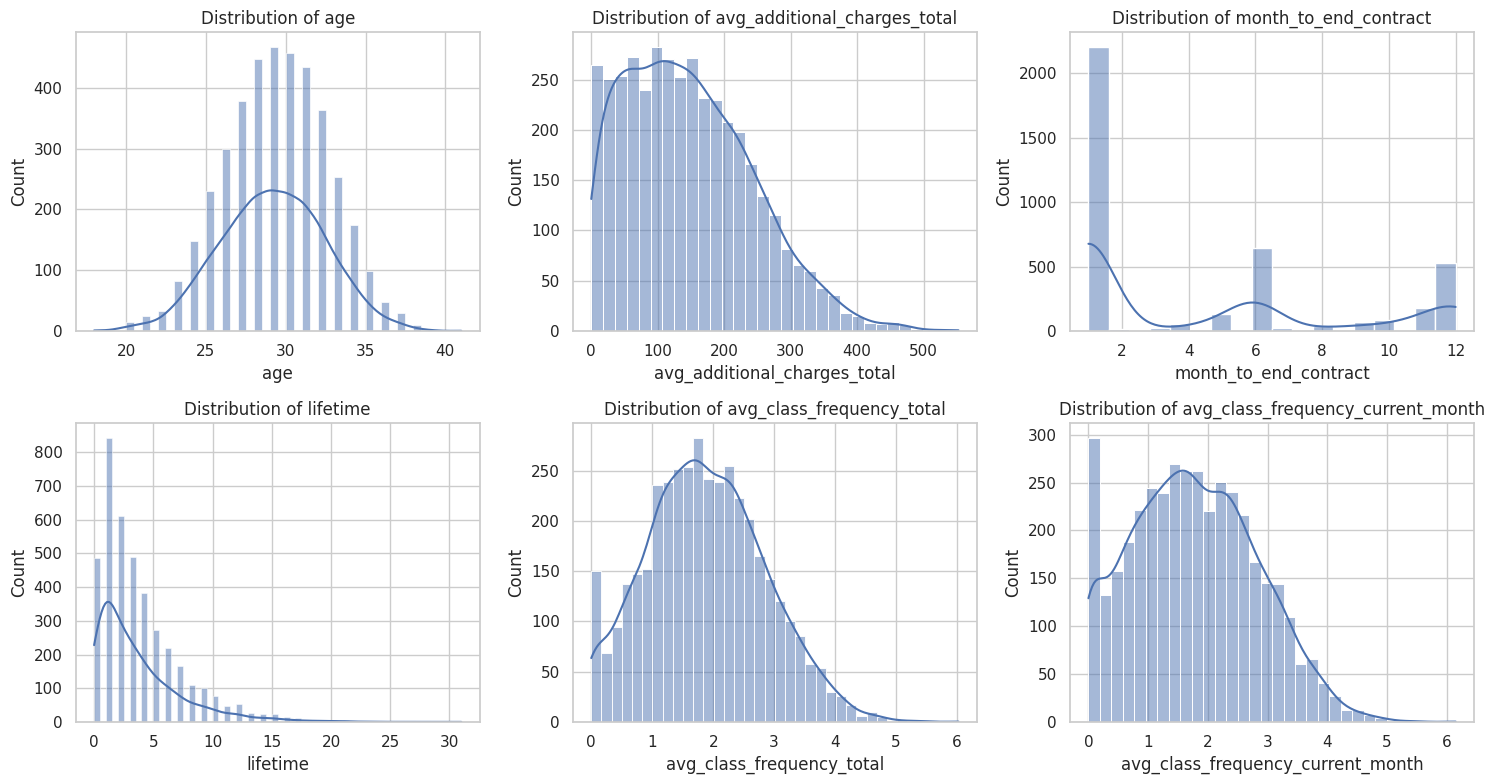

In [8]:
def plot_feature_distributions(dataframe):
    num_columns = 3
    num_features = len(dataframe.columns)
    num_rows = (num_features // num_columns) + (num_features % num_columns > 0)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 4))
    axes = axes.flatten()

    for idx, col in enumerate(dataframe.columns):
        sns.histplot(dataframe[col], kde=True, ax=axes[idx])
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

plot_feature_distributions(gym_data[columns_to_plot])

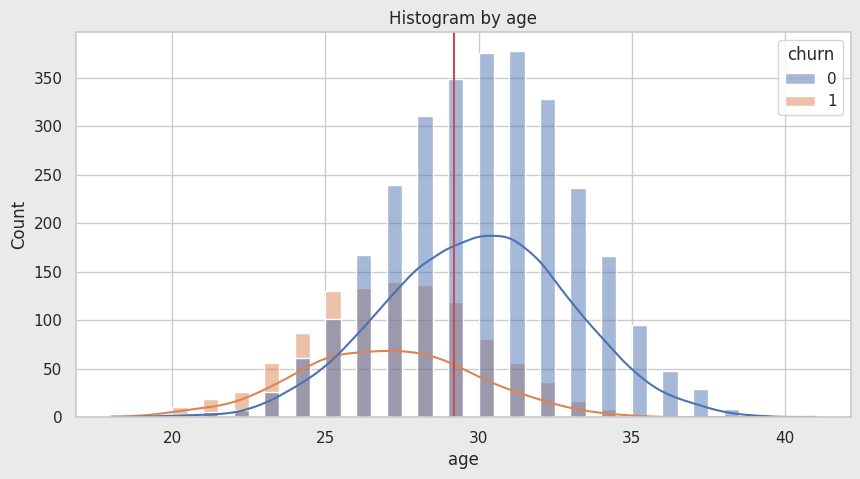

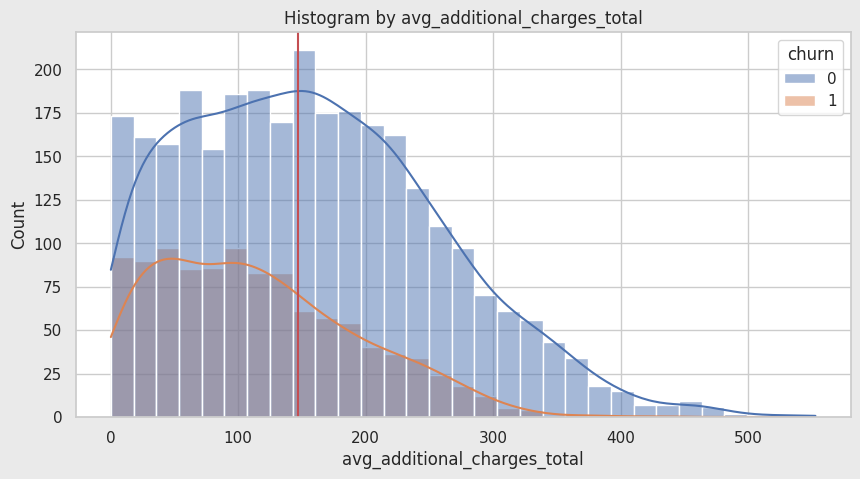

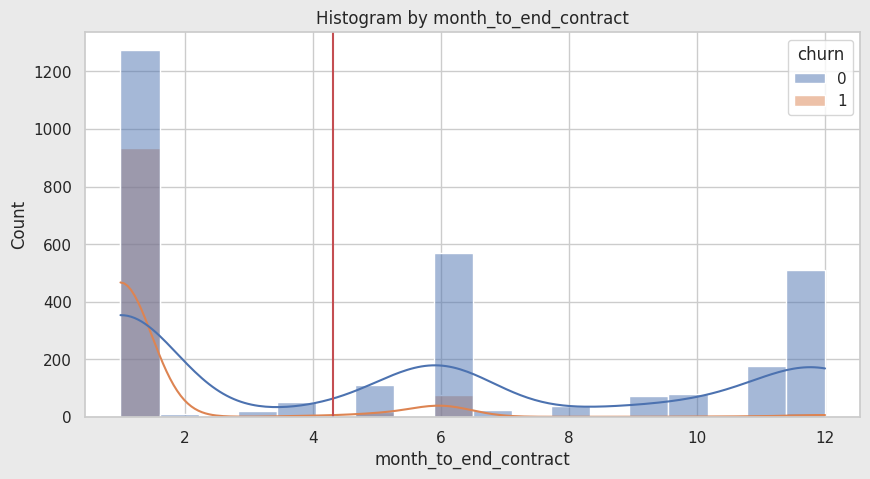

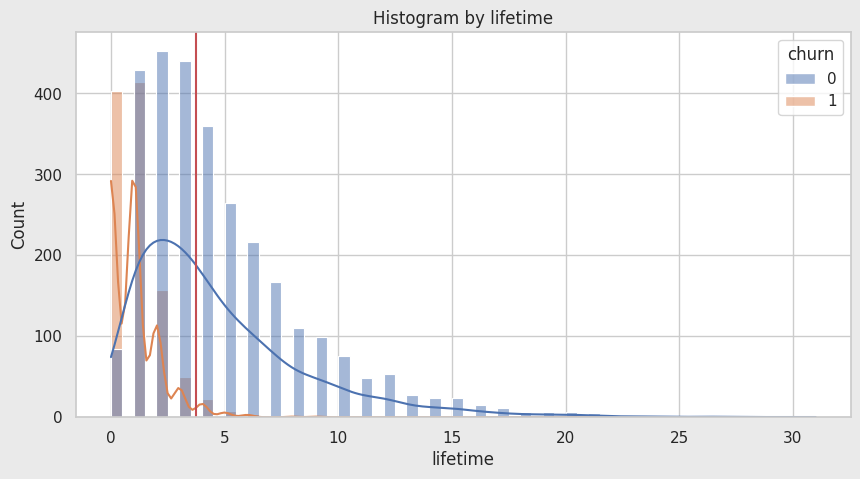

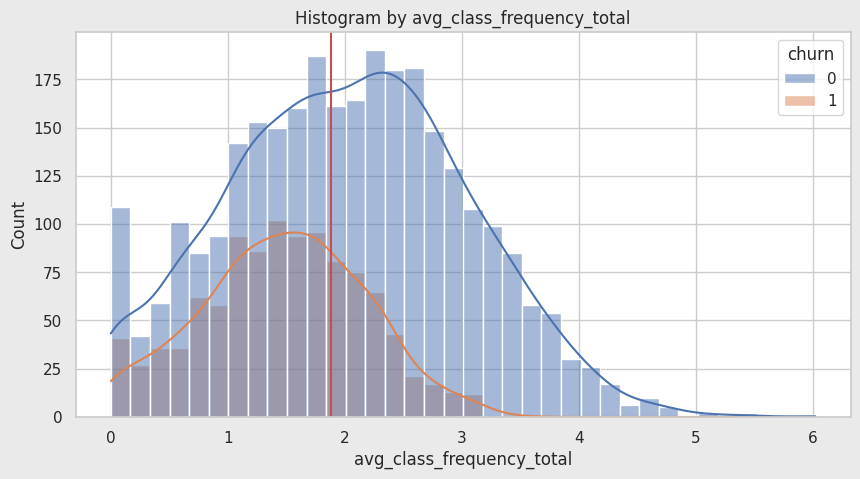

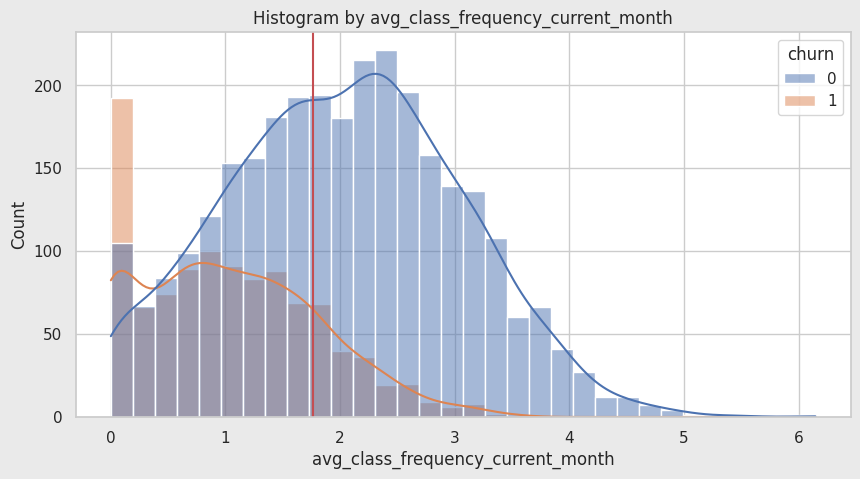

In [9]:
for col in columns_to_plot:
    mean=gym_data[col].mean()
    fig, ax = plt.subplots(figsize=(10,5),facecolor=facecolor)
    sns.histplot(data=gym_data, x=col, hue='churn', kde=True, ax=ax)
    plt.axvline(mean, color='r', linestyle='-', linewidth=1.5)
    title = f'Histogram by {col}'
    ax.set_title(title)
    plt.show()

### **More Analysis**

In [10]:
sns.set(style='whitegrid')

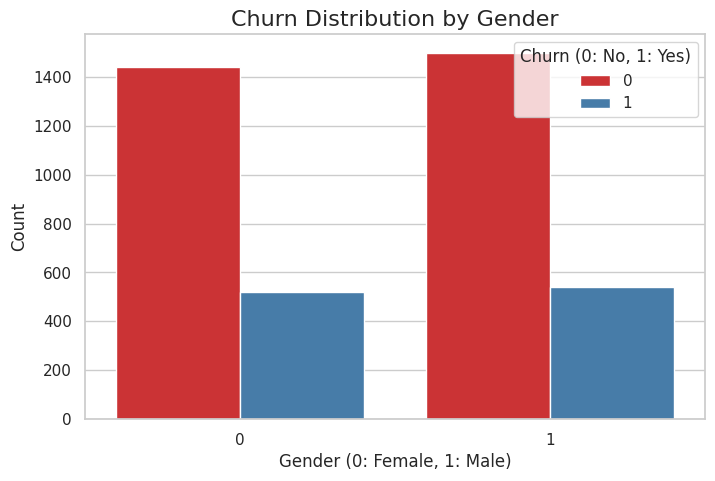

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=gym_data, x='gender', hue='churn', palette='Set1')
plt.title('Churn Distribution by Gender', fontsize=16)
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Count')
plt.legend(title='Churn (0: No, 1: Yes)')
plt.show()

/tmp/ipykernel_18392/1819423727.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gym_data, x='churn', y='contract_period', palette='Set1')


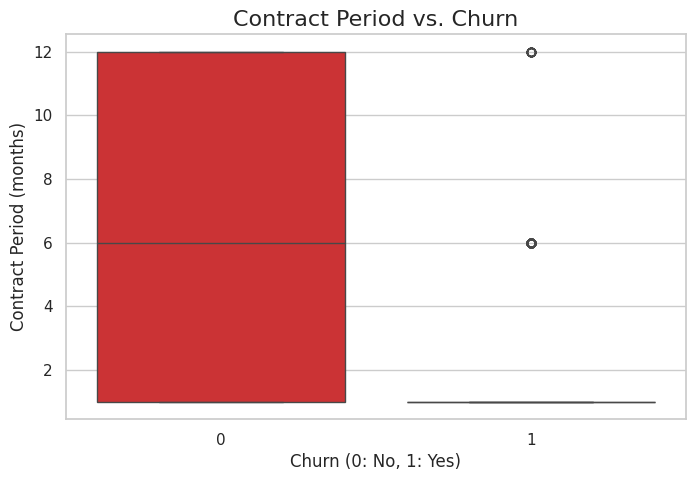

In [ ]:
# Contract Period vs. Churn
plt.figure(figsize=(8, 5))
sns.boxplot(data=gym_data, x='churn', y='contract_period', palette='Set1')
plt.title('Contract Period vs. Churn', fontsize=16)
plt.xlabel('Churn (0: No, 1: Yes)')
plt.ylabel('Contract Period (months)')
plt.show()

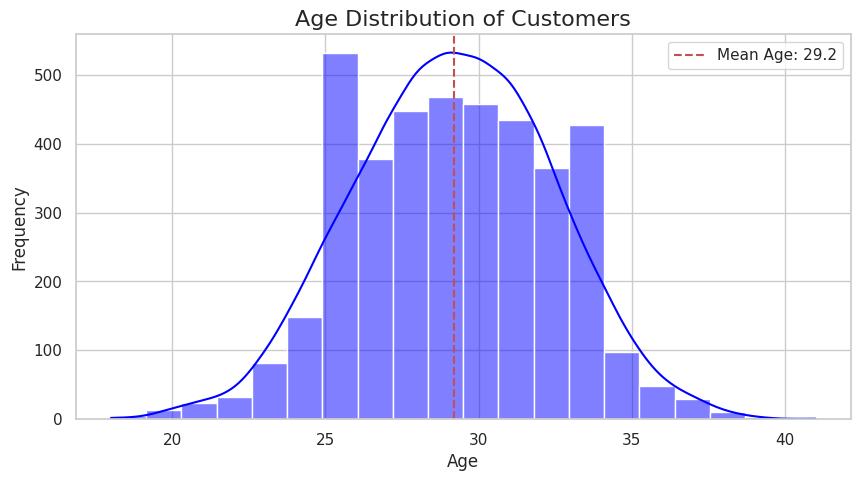

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(gym_data['age'], bins=20, kde=True, color='blue')
plt.axvline(gym_data['age'].mean(), color='r', linestyle='--', label=f'Mean Age: {gym_data["age"].mean():.1f}')
plt.title('Age Distribution of Customers', fontsize=16)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

- The plot indicates that the majority of customers are concentrated around the mid-20s to early 30s, with the mean age being approximately **29.2 years**.

- The distribution is somewhat right-skewed, indicating a few older customers.

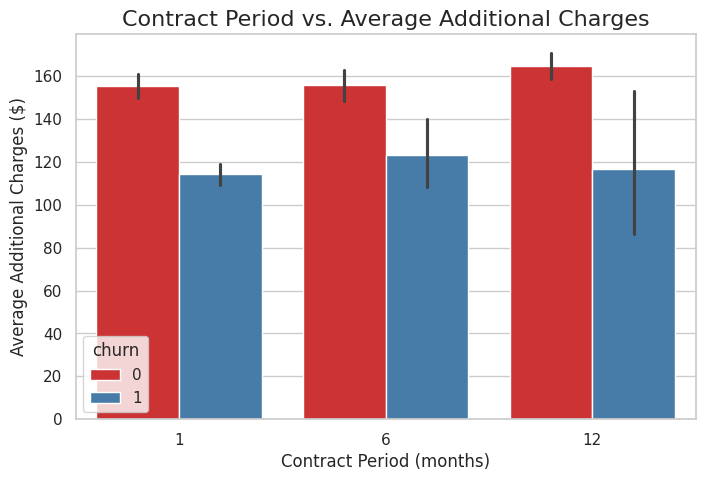

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=gym_data, x='contract_period', y='avg_additional_charges_total', hue='churn', palette='Set1')
plt.title('Contract Period vs. Average Additional Charges', fontsize=16)
plt.xlabel('Contract Period (months)')
plt.ylabel('Average Additional Charges ($)')
plt.show()

- **Shorter Contracts (1 month):** Customers with a 1-month contract who do not churn tend to spend significantly more on additional charges than those who churn. This suggests that non-churned users on short-term contracts might be highly engaged and willing to spend more.

- **Longer Contracts (6 and 12 months):** Non-churned customers in both the 6-month and 12-month contracts also tend to spend more than churned customers. Interestingly, there’s a notable drop in additional charges for churned customers across all contract durations, indicating that disengaged customers contribute less financially beyond their base contract.

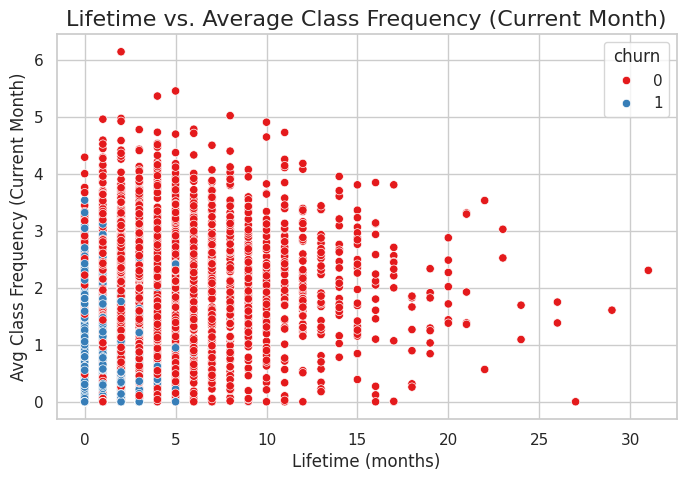

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=gym_data, x='lifetime', y='avg_class_frequency_current_month', hue='churn', palette='Set1')
plt.title('Lifetime vs. Average Class Frequency (Current Month)', fontsize=16)
plt.xlabel('Lifetime (months)')
plt.ylabel('Avg Class Frequency (Current Month)')
plt.show()

- **Churned Customers:**
    
    Many of the churned customers (blue points) appear concentrated around a shorter lifetime (0–6 months) and lower class frequency, suggesting that customers who attend fewer classes and have shorter memberships tend to churn more frequently.

- **Non-Churned Customers:**

    The red points (non-churned customers) are spread across longer lifetimes and higher class frequencies, indicating more consistent gym usage over time.

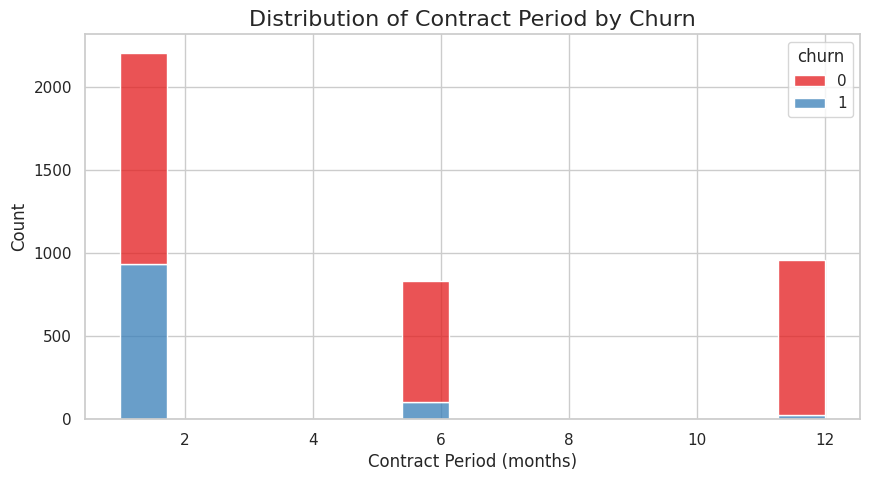

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=gym_data, x='contract_period', hue='churn', multiple='stack', palette='Set1', bins=15)
plt.title('Distribution of Contract Period by Churn', fontsize=16)
plt.xlabel('Contract Period (months)')
plt.ylabel('Count')
plt.show()

- **Short-Term Contracts (1 month):**

    The plot reveals that most churned customers (blue) are concentrated within the 1-month contract period. This suggests that shorter contracts are highly correlated with churn.

- **Medium-Term and Long-Term Contracts (6 and 12 months):**

    Customers with 6-month and 12-month contracts are much less likely to churn. Almost all customers with these longer contract periods do not churn (red).

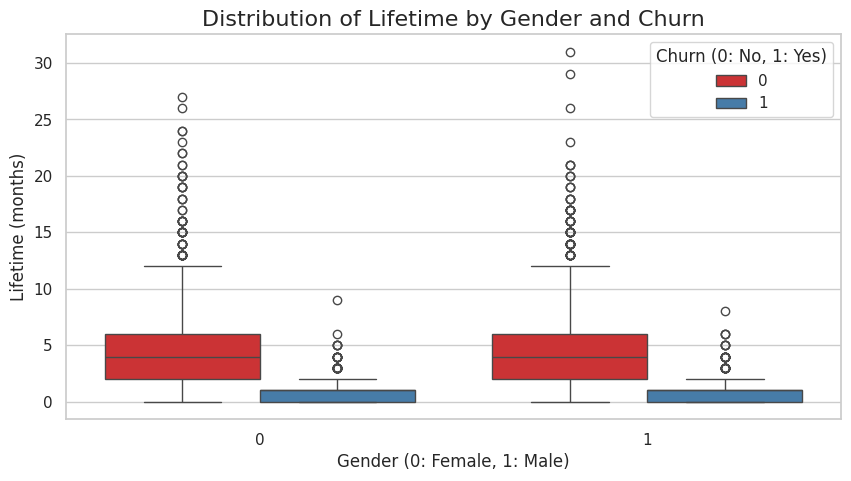

In [17]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=gym_data, x='gender', y='lifetime', hue='churn', palette='Set1')
plt.title('Distribution of Lifetime by Gender and Churn', fontsize=16)
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Lifetime (months)')
plt.legend(title='Churn (0: No, 1: Yes)')
plt.show()

- **Non-Churned Customers:**

    Both male and female customers who did not churn (red boxes) tend to have longer lifetimes, with medians close to 5 months. The spread for non-churned customers is wider, indicating greater variability in lifetime, with some customers remaining for more than 20 months.

- **Churned Customers:**

    Churned customers (blue boxes) have much shorter lifetimes, typically less than 1–2 months for both genders. The spread is narrower, and the presence of outliers indicates that a few churned customers had relatively longer lifetimes.

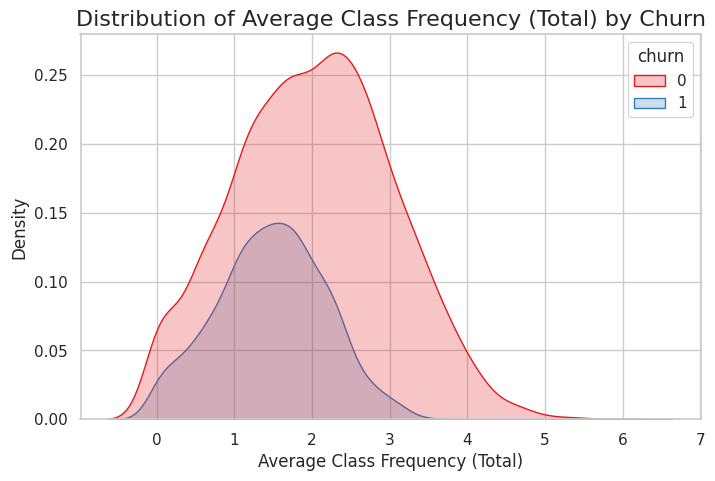

In [18]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=gym_data, x='avg_class_frequency_total', hue='churn', fill=True, palette='Set1')
plt.title('Distribution of Average Class Frequency (Total) by Churn', fontsize=16)
plt.xlabel('Average Class Frequency (Total)')
plt.ylabel('Density')
plt.show()

- **Non-Churned Customers (red curve):**

    Non-churned customers tend to have a higher average class frequency, peaking around 2–3 classes per month. This indicates that customers who attend classes more frequently are less likely to churn.

- **Churned Customers (blue curve):**

    The blue curve shows that churned customers generally have lower average class attendance, with a peak around 1 class per month or fewer.

/tmp/ipykernel_18392/4270430277.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gym_data, x='churn', y='month_to_end_contract', palette='Set1')


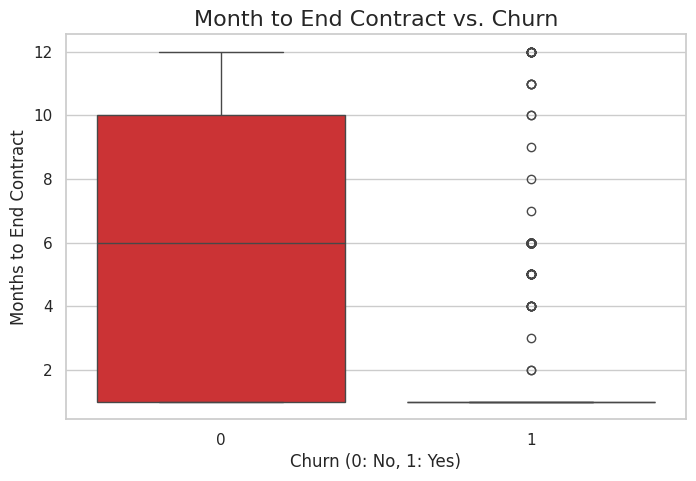

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=gym_data, x='churn', y='month_to_end_contract', palette='Set1')
plt.title('Month to End Contract vs. Churn', fontsize=16)
plt.xlabel('Churn (0: No, 1: Yes)')
plt.ylabel('Months to End Contract')
plt.show()

- **Non-Churned Customers (0):**

    Non-churned customers generally have more months remaining on their contracts, with a median around 6 months. The distribution also shows a wide range of remaining months (with some customers having up to 12 months left).

- **Churned Customers (1):**
    
    Churned customers tend to have very few months left on their contracts, with a median close to zero. This suggests that customers who are close to the end of their contracts are much more likely to churn.

### Feature Exploration Summary

1. **Age Distribution (Symmetrical for Both Groups):**
   - The frequency of churners is noticeably lower than non-churners.
   - Churners are predominantly between 25 and 30 years old, while non-churners peak between 30 and 33 years old.

2. **Additional Charges Distribution (Right-Skewed):**
   - Both groups exhibit right-skewed distributions, indicating that additional charges tend to remain low, typically below $200, with a median of $136.
   - Non-churners tend to spend more, likely due to their longer contract periods and customer lifetimes.

3. **Months Until Contract End Distribution (Unconventional):**
   - Most users, across both groups, have 1 month left on their contract.
   - Other notable groups include users with 6 and 12 months remaining.
   - Few users have contracts ending at other timeframes, with a median contract length of 5 months.

4. **Customer Lifetime Distribution (Right-Skewed):**
   - As expected, churners have a lifetime of less than 5 months.
   - While some non-churners have a lifetime extending beyond 20 months, the highest frequency of non-churners still falls below 5 months.

5. **Total Classes Attended (Right-Skewed):**
   - No user attends more than 6 classes throughout their membership.
   - The distributions show that non-churners attend more than 2 classes, while churners, with shorter contracts, attend fewer classes overall.

6. **Classes Attended in the Current Month (Right-Skewed):**
   - Most users did not attend any classes in the current month.
   - Non-churners, however, tend to attend at least 2 classes per month based on the histogram.


## Correlation Matrix: Relationship between different features

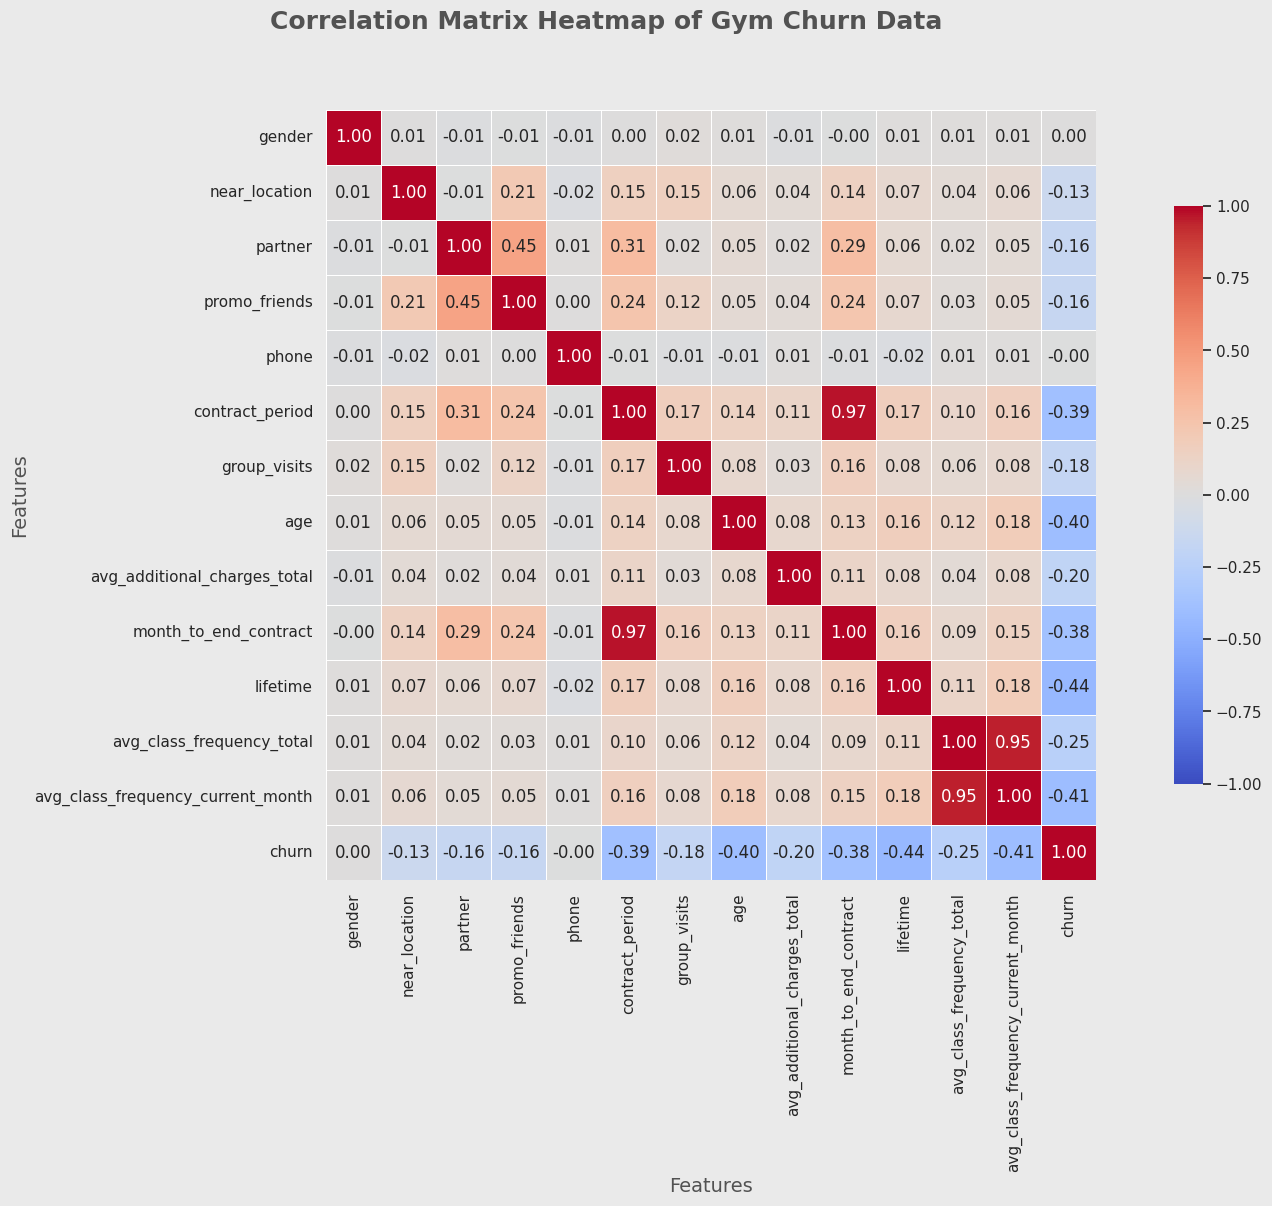

In [20]:
corr_matrix = gym_data.corr()

fig, ax = plt.subplots(figsize=(20, 10), facecolor=facecolor)

sns.heatmap(
    corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
    square=True, vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": 0.75}
)

title = 'Correlation Matrix Heatmap of Gym Churn Data'
fig.suptitle(title, fontsize=18, fontweight='bold', color=font_color)

ax.set_xlabel('Features', fontsize=14, color=font_color)
ax.set_ylabel('Features', fontsize=14, color=font_color)
plt.show()

In [21]:
corr_matrix['churn'].sort_values()

lifetime                            -0.438220
avg_class_frequency_current_month   -0.412348
age                                 -0.404735
contract_period                     -0.389984
month_to_end_contract               -0.381393
avg_class_frequency_total           -0.249715
avg_additional_charges_total        -0.198697
group_visits                        -0.175325
promo_friends                       -0.162233
partner                             -0.157986
near_location                       -0.128098
phone                               -0.001177
gender                               0.000708
churn                                1.000000
Name: churn, dtype: float64

### Correlation Insights

The dataset reveals several factors correlated with customer churn. Notably, customer lifetime has the strongest negative correlation, followed by average class attendance in the current month and customer age. This indicates that less active users, especially those under the age of 30, are more likely to churn.

**Key factors contributing to churn:**
1. Age
2. Customer lifetime
3. Contract duration
4. Class attendance frequency

**Positive correlations:**
1. Friend promotions
2. Relationships with employees or referrals by friends of employees

### Exploratory Analysis Summary

From our exploration, we can formulate several hypotheses to guide further analysis and develop a model to better understand customer behavior, ultimately aiding in customer retention strategies.

**Hypothesis 1:**
- **H0:** Users under the age of 35 are likely to leave the gym within 2 months of joining.
- **H1:** Users over the age of 35 are generally more active compared to younger users.

**Hypothesis 2:**
- **H0:** Customers who attend more classes are likely to stay longer.
- **H1:** Customers who do not attend at least one class per month are more likely to churn.

**Hypothesis 3:**
- **H0:** Customers with contracts longer than 6 months are less likely to churn compared to monthly customers.
- **H1:** Monthly customers have a higher churn rate compared to those with 12-month contracts.

# Build a Model to Predict User Churn

1) **Binary Classification Model Setup:**
   - Our goal is to build a binary classification model where the target feature is predicting whether a user will leave the gym next month.

2) **Data Split into Training and Validation Sets:**
   - Use the `train_test_split()` function to divide the dataset into training and validation sets. The target column for this task is the churn status (user leaving next month).

3) **Model Training:**
   - Train two models on the training dataset:
     - **Logistic Regression**
     - **Random Forest**

4) **Model Evaluation:**
   - Evaluate both models using the validation data by calculating:
     - **Accuracy**
     - **Precision**
     - **Recall**
   - Compare these metrics to determine which model performs better.

5) **Ensure Random State Consistency:**
   - When dividing the dataset and defining the algorithms, ensure to use the `random_state` parameter for reproducibility.

## Feature Selection

To build a more effective model, we need to select the most relevant features that align with our hypotheses and customer behavior patterns. Based on our earlier analysis, we will focus on the following features:

1. **Class Frequency (Total):** The total number of classes attended by the user over the course of their contract, as it may indicate engagement and likelihood to stay.
2. **Customer Lifetime:** The length of time a customer has stayed with the gym, which can strongly influence the probability of churn.
3. **Additional Charges:** The amount spent on additional services beyond the standard contract, providing insight into user engagement.
4. **Contract Period:** The length of the user's current contract, which directly correlates with churn behavior.
5. **Customer Age:** Age may be a key factor, as younger customers appear more likely to churn based on previous findings.

These selected features will be used to train the model for predicting customer churn.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

In [23]:
X_features = gym_data[['lifetime','avg_class_frequency_current_month','age','contract_period',
                         'avg_class_frequency_total','avg_additional_charges_total','month_to_end_contract']]
y_variable = gym_data['churn']


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_variable, test_size=0.2, random_state=42, shuffle=True)

In [25]:
# Standardize the features
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [26]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=3000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=0),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=0),
    'Decision Tree': DecisionTreeClassifier(random_state=0)
}

In [27]:
model_results = {}
def evaluate_model(name, model, X_train_st, X_test_st, y_train, y_test):
    model.fit(X_train_st, y_train)
    predictions = model.predict(X_test_st)
    probabilities = model.predict_proba(X_test_st)[:,1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)

    # Store the results
    model_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    # Display evaluation metrics
    print(f"\n{name} Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="red")
    plt.title(f"{name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()


Logistic Regression Model Evaluation Metrics:
Accuracy: 0.92
Precision: 0.88
Recall: 0.78
F1 Score: 0.83
ROC AUC: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       598
           1       0.88      0.78      0.83       202

    accuracy                           0.92       800
   macro avg       0.90      0.87      0.89       800
weighted avg       0.92      0.92      0.92       800



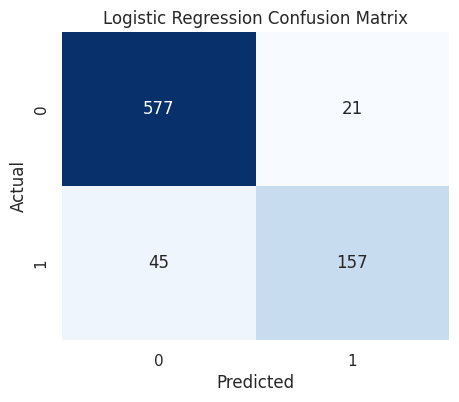

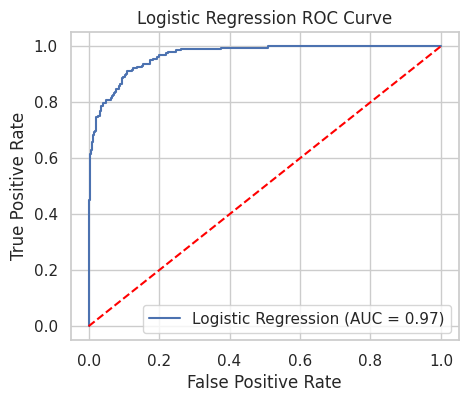


Random Forest Model Evaluation Metrics:
Accuracy: 0.91
Precision: 0.85
Recall: 0.79
F1 Score: 0.82
ROC AUC: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       598
           1       0.85      0.79      0.82       202

    accuracy                           0.91       800
   macro avg       0.89      0.87      0.88       800
weighted avg       0.91      0.91      0.91       800



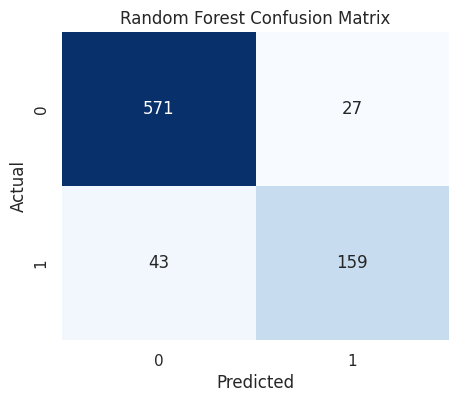

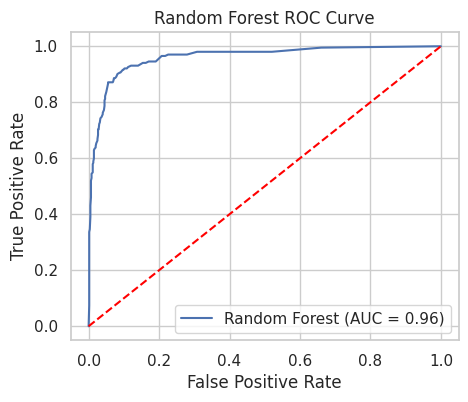


Gradient Boosting Model Evaluation Metrics:
Accuracy: 0.93
Precision: 0.88
Recall: 0.82
F1 Score: 0.85
ROC AUC: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       598
           1       0.88      0.82      0.85       202

    accuracy                           0.93       800
   macro avg       0.91      0.89      0.90       800
weighted avg       0.92      0.93      0.92       800



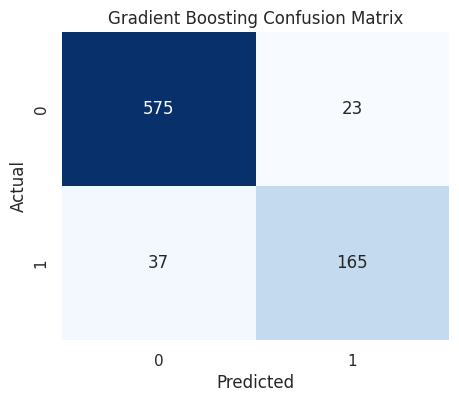

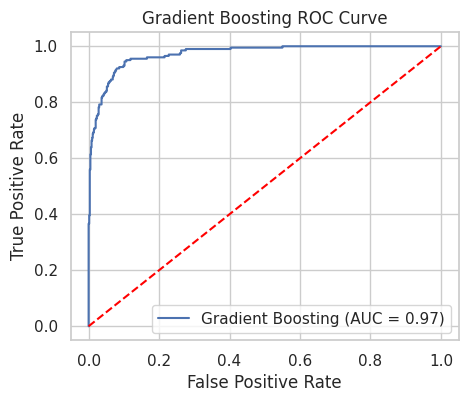


Decision Tree Model Evaluation Metrics:
Accuracy: 0.89
Precision: 0.78
Recall: 0.78
F1 Score: 0.78
ROC AUC: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       598
           1       0.78      0.78      0.78       202

    accuracy                           0.89       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.89      0.89      0.89       800



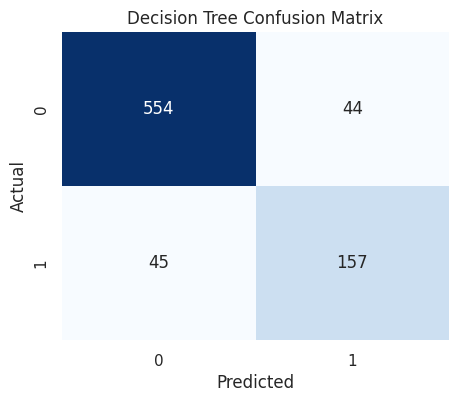

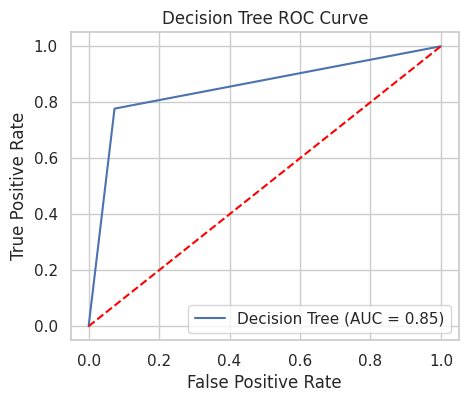

In [28]:
for name, model in models.items():
    evaluate_model(name, model, X_train_st, X_test_st, y_train, y_test)

In [29]:
performance_df = pd.DataFrame(model_results).T
print("\nModel Performance Comparison:\n")
print(performance_df)


Model Performance Comparison:

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression   0.91750   0.882022  0.777228  0.826316  0.967135
Random Forest         0.91250   0.854839  0.787129  0.819588  0.959982
Gradient Boosting     0.92500   0.877660  0.816832  0.846154  0.972487
Decision Tree         0.88875   0.781095  0.777228  0.779156  0.851825


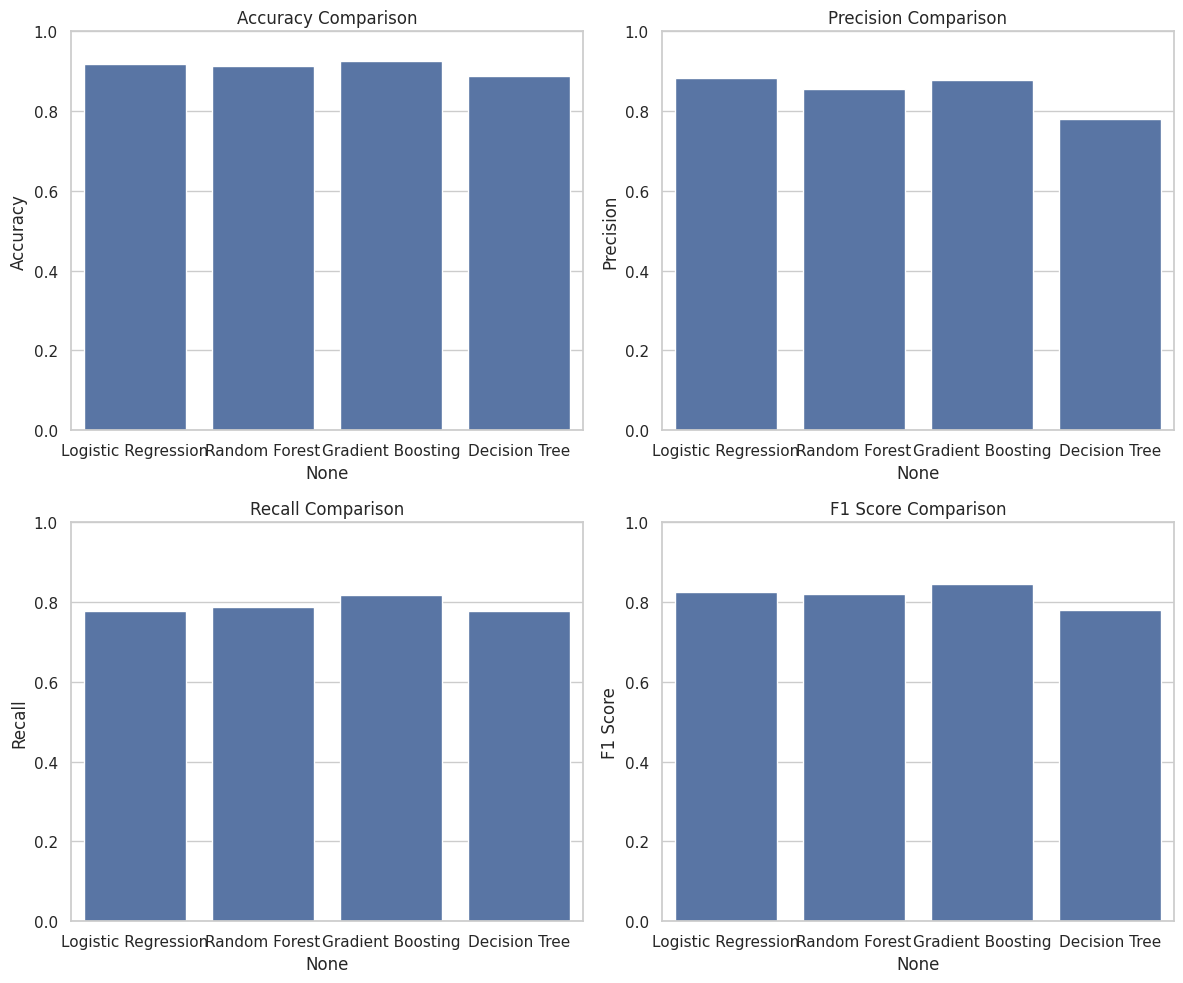

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for i, metric in enumerate(metrics):
    sns.barplot(x=performance_df.index, y=performance_df[metric], ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f"{metric} Comparison")
    ax[i//2, i%2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [31]:
def plot_feature_importance(model, model_name, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(8, 5))
        sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="viridis")
        plt.title(f"Feature Importance - {model_name}")
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.show()


/tmp/ipykernel_18392/1180133388.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="viridis")


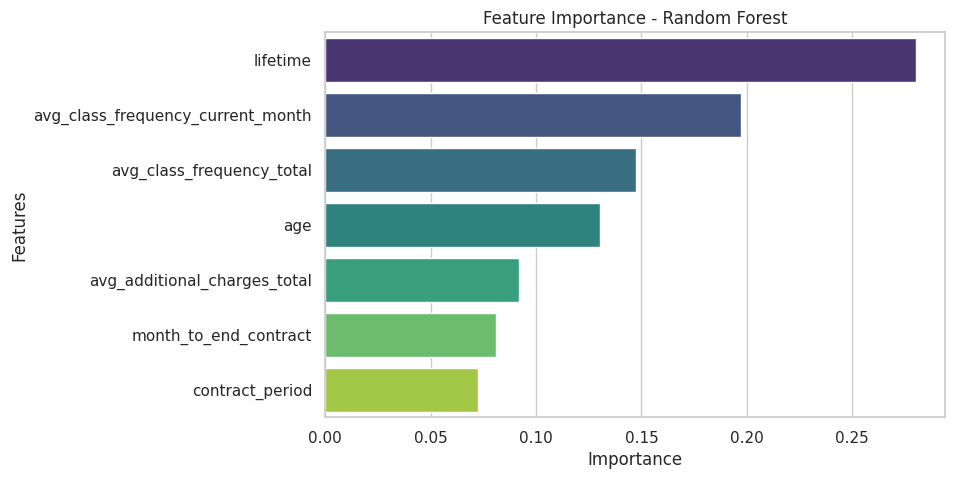

In [32]:
# Plot feature importance for Random Forest and Gradient Boosting models
plot_feature_importance(models['Random Forest'], 'Random Forest', X_features.columns)

/tmp/ipykernel_18392/1180133388.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="viridis")


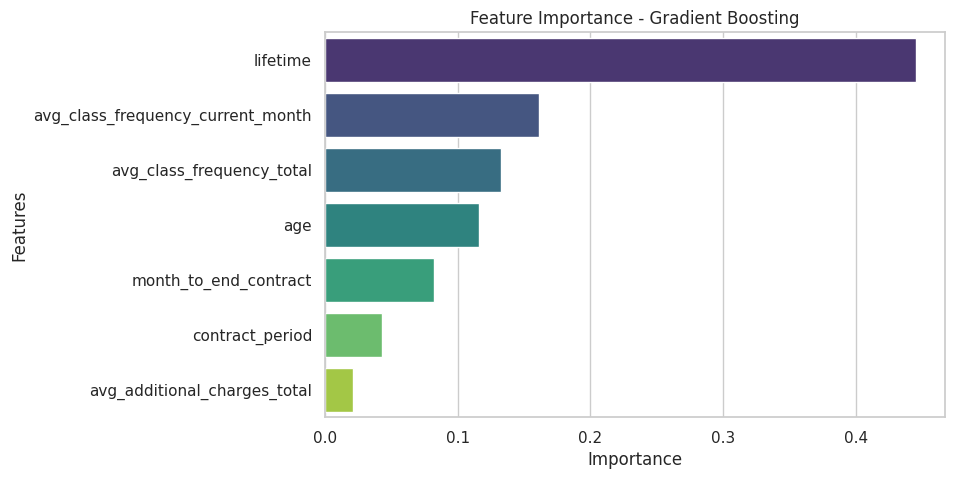

In [33]:
plot_feature_importance(models['Gradient Boosting'], 'Gradient Boosting', X_features.columns)

### Interpretation of Model Performance Comparison

The table summarizes the performance of four models—Logistic Regression, Random Forest, Gradient Boosting, and Decision Tree—based on several metrics: Accuracy, Precision, Recall, F1 Score, and ROC AUC. Let's break down each metric and interpret the results.

#### 1. **Accuracy**
- **Logistic Regression**: 91.75%
- **Random Forest**: 91.25%
- **Gradient Boosting**: 92.50% (Best accuracy)
- **Decision Tree**: 88.88% (Lowest accuracy)

Accuracy represents the proportion of correct predictions out of the total predictions. Here, **Gradient Boosting** has the highest accuracy, slightly better than Logistic Regression and Random Forest, indicating that it makes the most correct predictions overall. **Decision Tree** has the lowest accuracy, suggesting it may be less reliable in correctly predicting the target variable (`churn`).

#### 2. **Precision**
- **Logistic Regression**: 88.20%
- **Random Forest**: 85.48%
- **Gradient Boosting**: 87.77%
- **Decision Tree**: 78.11% (Lowest precision)

Precision measures the ability of the model to avoid false positives (i.e., predicting churn when the customer didn’t churn). In this case, **Logistic Regression** and **Gradient Boosting** have the highest precision, meaning they are better at correctly identifying customers who actually churned without misclassifying non-churners. **Decision Tree** has the lowest precision, indicating a higher likelihood of false positives.

#### 3. **Recall**
- **Logistic Regression**: 77.72%
- **Random Forest**: 78.71%
- **Gradient Boosting**: 81.68% (Best recall)
- **Decision Tree**: 77.72%

Recall measures the ability of the model to identify true positives (i.e., correctly predicting churn). **Gradient Boosting** has the highest recall, meaning it’s better at identifying a higher proportion of actual churners. **Logistic Regression** and **Decision Tree** have similar recall, which is lower than Gradient Boosting, meaning they miss slightly more churners compared to Gradient Boosting.

#### 4. **F1 Score**
- **Logistic Regression**: 82.63%
- **Random Forest**: 81.96%
- **Gradient Boosting**: 84.61% (Best F1 score)
- **Decision Tree**: 77.91% (Lowest F1 score)

The F1 score is a balance between precision and recall. **Gradient Boosting** has the highest F1 score, indicating that it strikes the best balance between precision and recall, making it a more robust model for churn prediction. **Decision Tree** has the lowest F1 score, showing that it’s less effective in balancing false positives and false negatives.

#### 5. **ROC AUC (Receiver Operating Characteristic Area Under the Curve)**
- **Logistic Regression**: 0.967 (Excellent)
- **Random Forest**: 0.959
- **Gradient Boosting**: 0.972 (Best ROC AUC)
- **Decision Tree**: 0.851 (Lowest ROC AUC)

ROC AUC represents the model's ability to distinguish between the two classes (churn and non-churn) across different thresholds. A higher AUC indicates a better ability to separate churners from non-churners. **Gradient Boosting** has the highest AUC at 0.972, meaning it is excellent at distinguishing between churners and non-churners across all thresholds. **Decision Tree** has the lowest AUC, suggesting that it is less reliable when it comes to separating the two classes.

### Overall Model Performance Summary:
1. **Gradient Boosting**: Overall, Gradient Boosting performs the best across all metrics. It has the highest accuracy, recall, F1 score, and ROC AUC. It balances precision and recall effectively and is highly capable of distinguishing between churners and non-churners. This model would likely be the best choice for predicting gym customer churn.
   
2. **Logistic Regression**: Logistic Regression performs well, particularly in terms of precision and ROC AUC. While its recall is slightly lower than Gradient Boosting, it is still a reliable model for churn prediction.

3. **Random Forest**: Random Forest is also a strong model, with solid performance across all metrics. It is slightly behind Logistic Regression and Gradient Boosting but still a viable option, particularly if you value interpretability through feature importance.

4. **Decision Tree**: Decision Tree consistently underperforms compared to the other models, with lower accuracy, precision, F1 score, and AUC. Its simpler structure may lead to overfitting and reduced generalization capability. This model is likely the least suitable for this particular task.

## Create User Clusters

1) **Standardize the Data:**
   - Standardize the feature matrix to ensure all features are on the same scale before clustering.

2) **Build a Distance Matrix and Plot a Dendrogram:**
   - Use the `linkage()` function to compute a matrix of distances based on the standardized features.
   - Plot a dendrogram to visually assess the number of potential clusters. (Note: Plotting the dendrogram may take time. Use it to estimate how many clusters to choose.)

3) **Train a K-means Clustering Model:**
   - Train the K-means algorithm to predict customer clusters. Set the number of clusters to **n=5** for comparison purposes.
   - (In real-world scenarios, the number of clusters would be decided based on the dendrogram or other clustering metrics.)

4) **Analyze Mean Feature Values for Clusters:**
   - Calculate the mean feature values for each cluster and examine any patterns or differences that stand out.

5) **Visualize Feature Distributions by Cluster:**
   - Plot the distribution of features across the clusters to observe any notable differences or trends.

6) **Calculate and Compare Churn Rates for Each Cluster:**
   - Use the `groupby()` method to calculate the churn rate for each cluster.
   - Analyze whether the clusters differ in terms of churn rate. Identify which clusters are more prone to churn and which exhibit loyalty.


In [34]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [35]:
sc = StandardScaler()
x_sc = sc.fit_transform(gym_data)

In [36]:
linked_data = linkage(x_sc, method='ward')

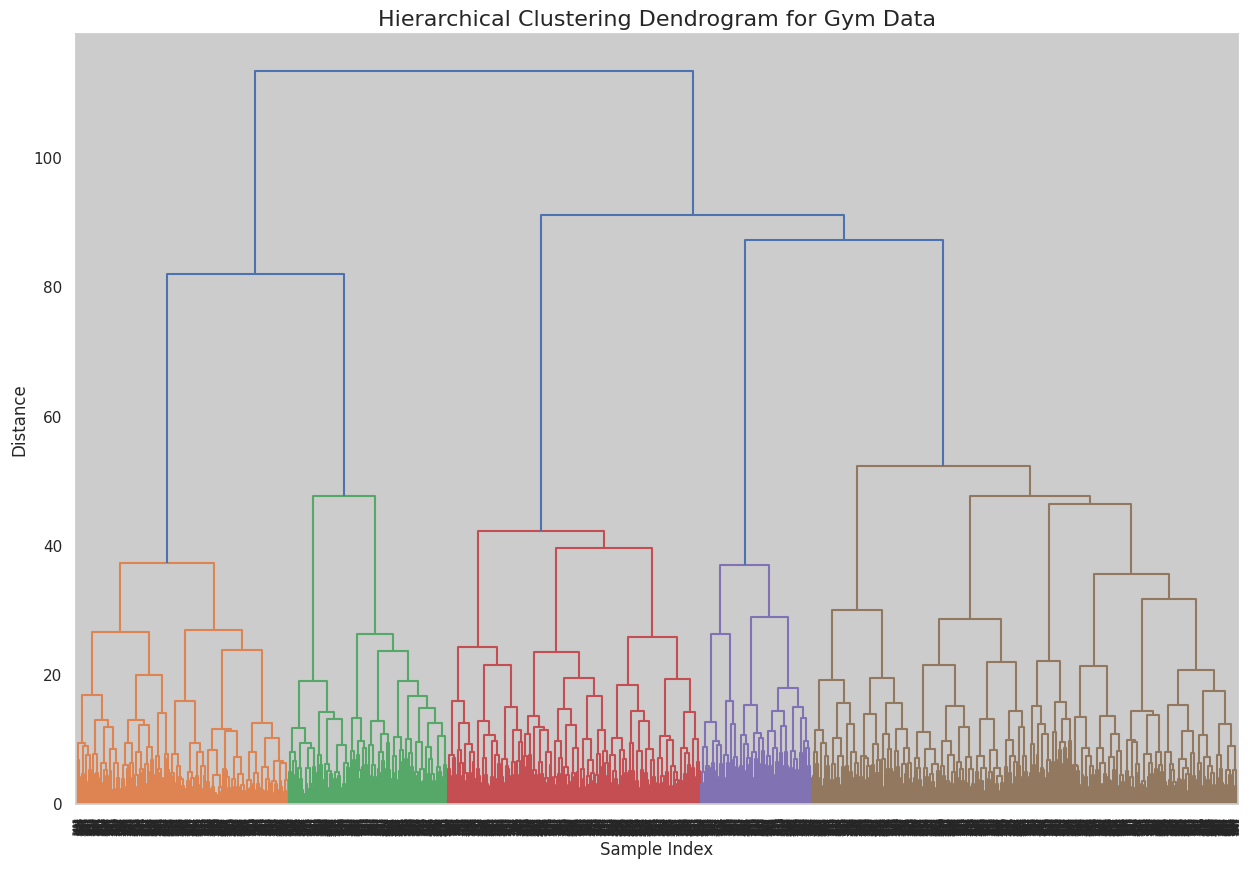

In [37]:
plt.figure(figsize=(15, 10))
dendrogram(linked_data, orientation='top')
plt.title('Hierarchical Clustering Dendrogram for Gym Data', fontsize=16)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.xticks(rotation='vertical')
plt.show()

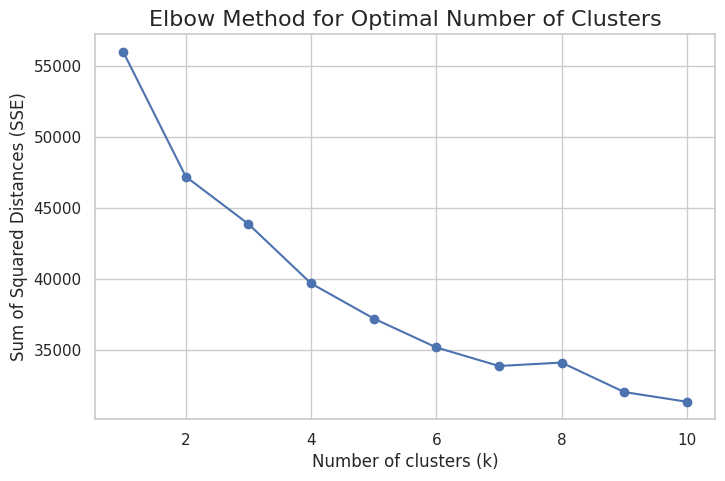

In [38]:
### Elbow Method to Determine Optimal K for K-means ###
# Function to calculate SSE (Sum of Squared Distances) for different cluster sizes
sse = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(x_sc)
    sse.append(km.inertia_)

# Plot the Elbow graph to find the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters', fontsize=16)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.show()

In [39]:
###Train K-means Clustering with 5 Clusters
km = KMeans(n_clusters=5, random_state=42)
labels = km.fit_predict(x_sc)

In [40]:
gym_data['cluster_km'] = labels

In [41]:
#compute the silhouette score to evaluate clustering quality
silhouette_avg = silhouette_score(x_sc, labels)
print(f'Silhouette Score for K-means with 5 clusters: {silhouette_avg:.2f}')

Silhouette Score for K-means with 5 clusters: 0.15


In [42]:
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,3
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,2
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,4
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,2
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,4


**Cluster Analysis: Mean Feature Values per Cluster**

In [43]:
cluster_summary = gym_data.groupby('cluster_km').agg({
    'gender':'mean',
    'near_location':'mean',
    'partner':'mean',
    'promo_friends':'mean',
    'phone':'mean',
    'contract_period':'mean',
    'group_visits':'mean',
    'age':'mean',
    'avg_additional_charges_total':'mean',
    'month_to_end_contract':'mean',
    'lifetime':'mean',
    'avg_class_frequency_total':'mean',
    'avg_class_frequency_current_month':'mean',
    'churn':'mean'
})
cluster_summary

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.508475,1.000000,0.332464,0.226858,1.0,1.646675,0.285528,26.915254,114.995594,1.594524,1.061278,1.402755,1.007382,0.932203
1,0.499033,0.000000,0.462282,0.077369,1.0,2.292070,0.216634,28.564797,136.165668,2.160542,2.843327,1.732190,1.554870,0.433269
2,0.506399,0.956124,0.786106,0.574954,1.0,10.628885,0.546618,29.887569,159.938050,9.675503,4.621572,2.007334,2.001950,0.013711
3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
4,0.515372,0.999191,0.332524,0.220874,1.0,2.269417,0.449029,30.193366,160.630304,2.137540,4.885113,2.130157,2.132761,0.003236


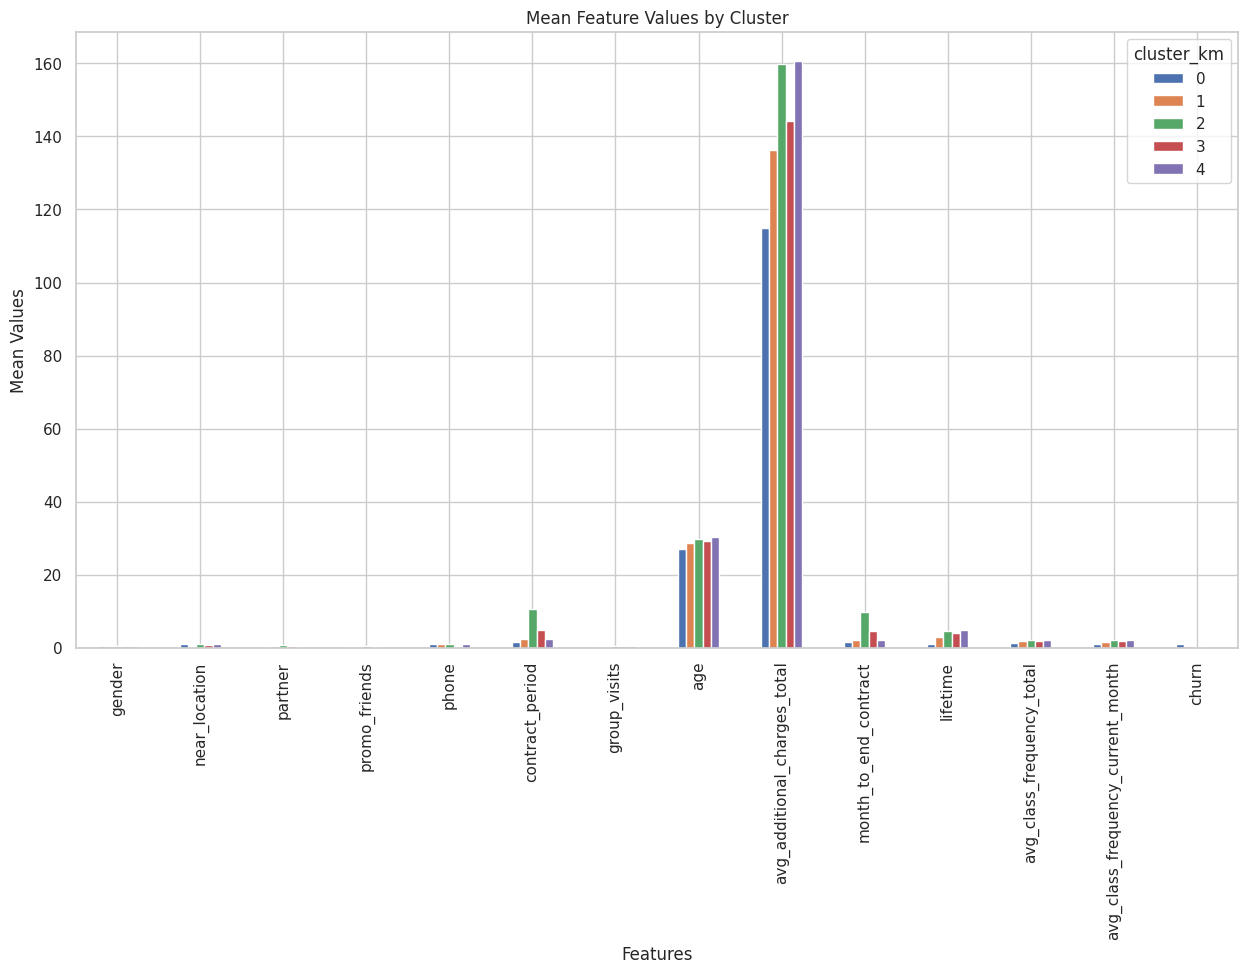

In [44]:
cluster_summary.T.plot(kind='bar', figsize=(15, 8), title='Mean Feature Values by Cluster')
plt.ylabel('Mean Values')
plt.xlabel('Features')
plt.show()

**Visualize Clusters on 2D Projections**

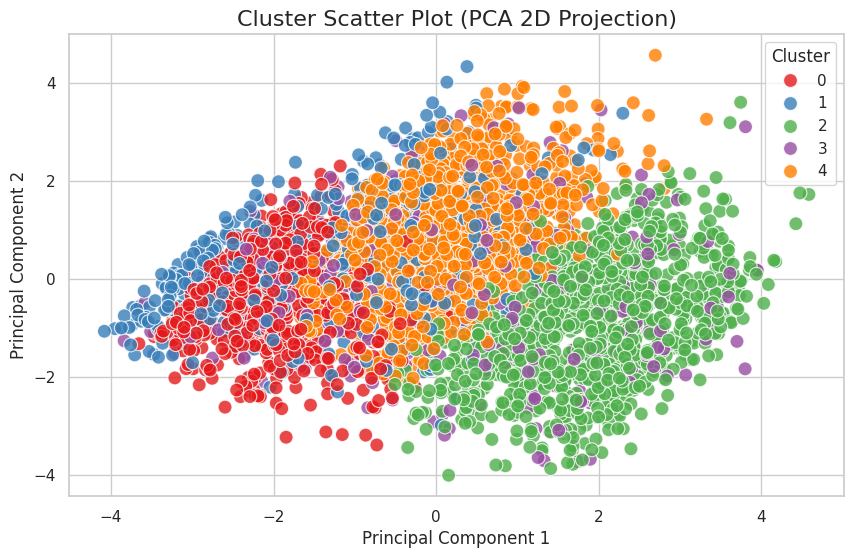

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_sc)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1', s=100, alpha=0.8)
plt.title('Cluster Scatter Plot (PCA 2D Projection)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Cluster")
plt.show()

**Distribution of Features by Cluster**

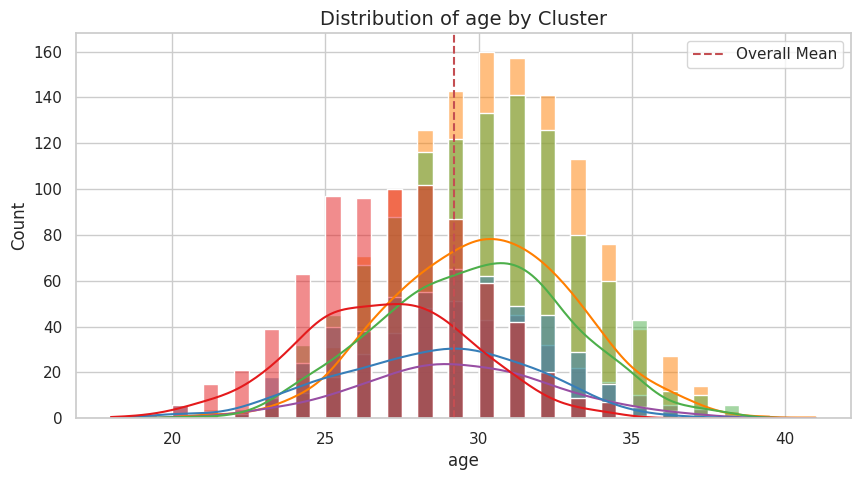

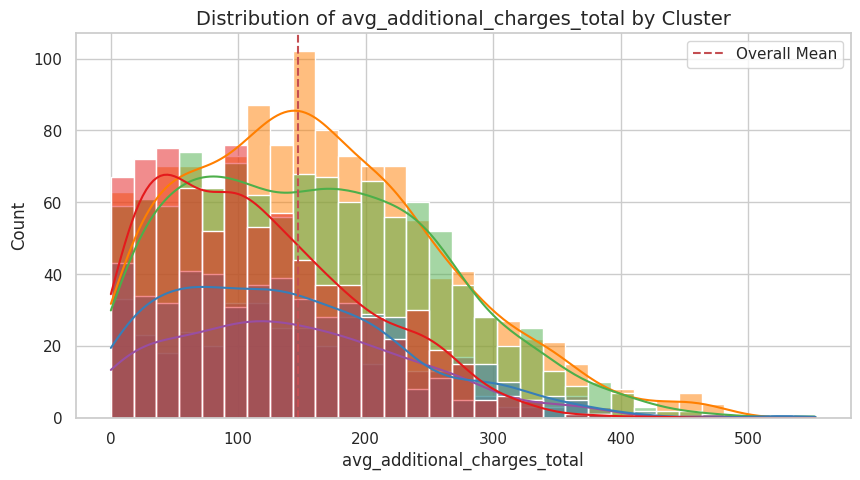

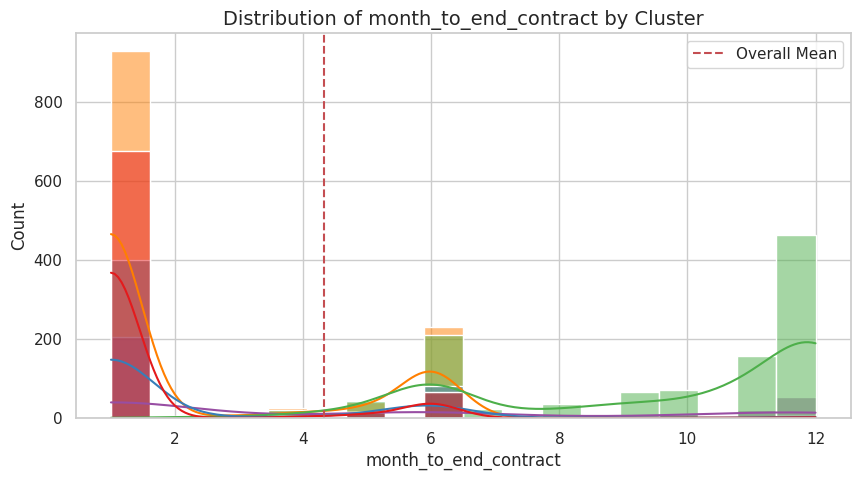

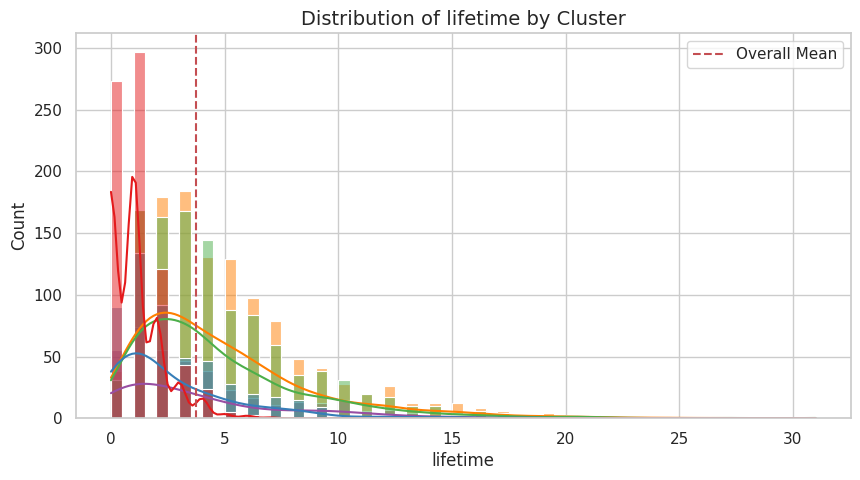

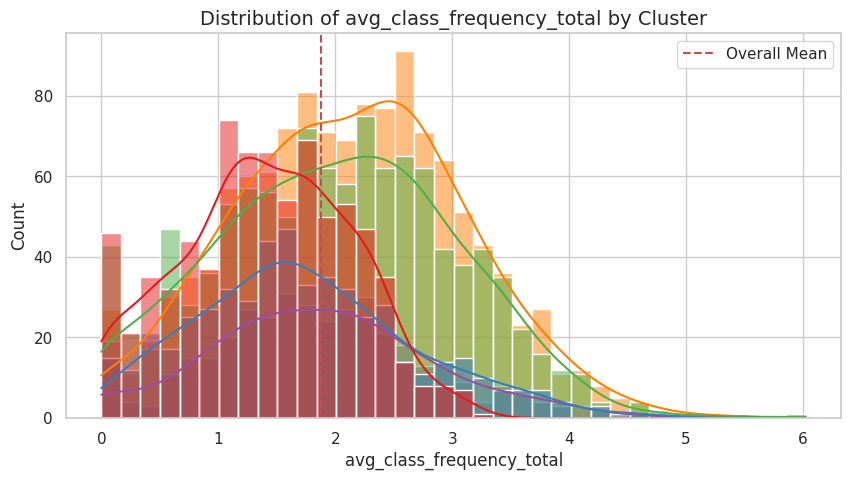

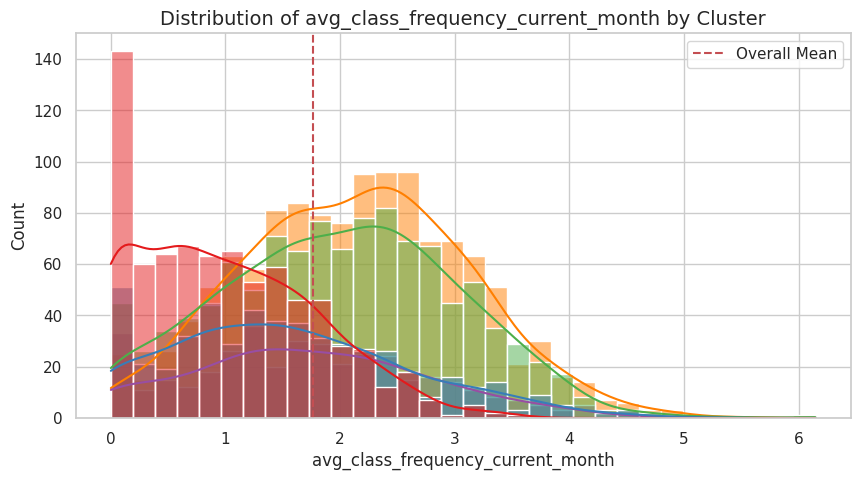

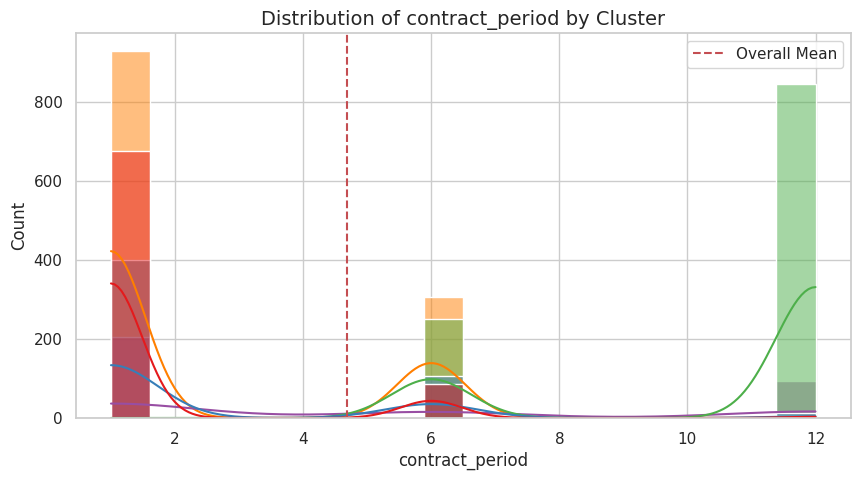

In [46]:
columns_to_plot_clusters = ['age', 'avg_additional_charges_total', 'month_to_end_contract',
                            'lifetime', 'avg_class_frequency_total',
                            'avg_class_frequency_current_month', 'contract_period']

for col in columns_to_plot_clusters:
    mean = gym_data[col].mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(data=gym_data, x=col, hue='cluster_km', kde=True, ax=ax, palette='Set1')
    plt.axvline(mean, color='r', linestyle='--', linewidth=1.5, label='Overall Mean')
    ax.set_title(f'Distribution of {col} by Cluster', fontsize=14)
    ax.legend()
    plt.show()

**Compare Feature Distributions by Cluster**

/tmp/ipykernel_18392/3127060391.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_km', y='lifetime', data=gym_data, palette='Set1')


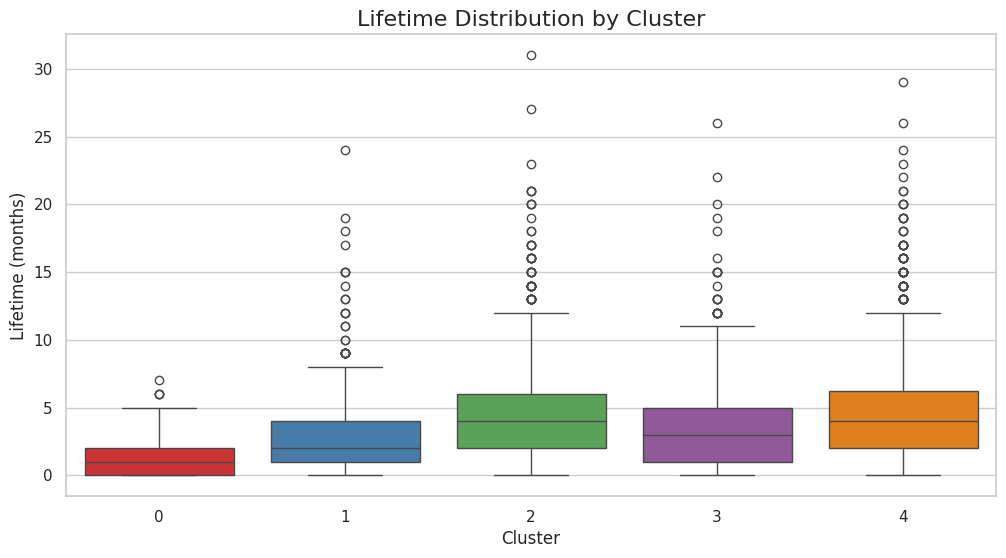

/tmp/ipykernel_18392/3127060391.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_km', y='contract_period', data=gym_data, palette='Set1')


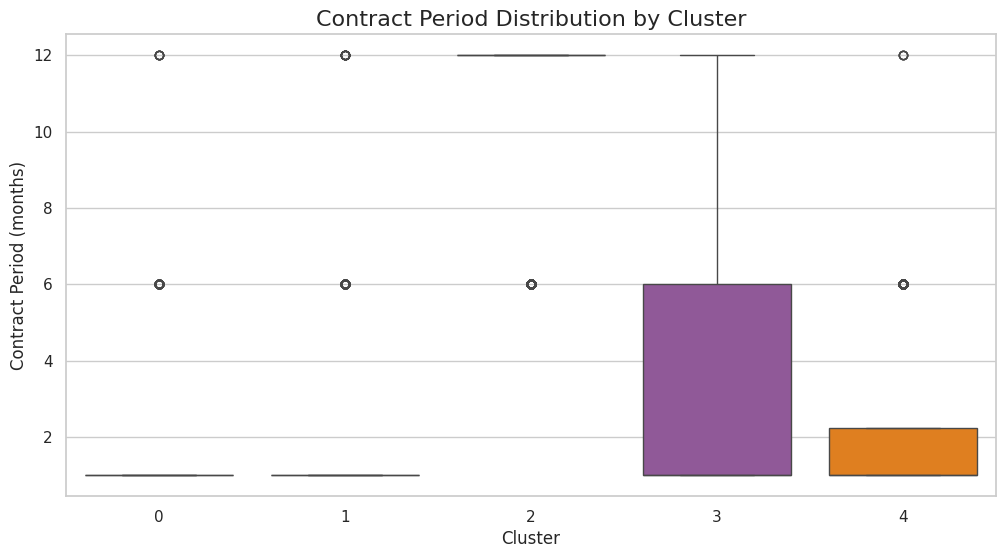

In [47]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster_km', y='lifetime', data=gym_data, palette='Set1')
plt.title('Lifetime Distribution by Cluster', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Lifetime (months)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster_km', y='contract_period', data=gym_data, palette='Set1')
plt.title('Contract Period Distribution by Cluster', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Contract Period (months)')
plt.show()

**Churn Rate by Cluster**

In [48]:
gym_data['churned'] = gym_data['churn'].where(gym_data['churn'] == 1, other=np.nan)
gym_data['non_churned'] = gym_data['churn'].where(gym_data['churn'] == 0, other=np.nan)

In [49]:
churn_rate = gym_data.groupby('cluster_km').agg({
    'churned':'count',
    'non_churned':'count'
})
churn_rate['customers_at_start'] = churn_rate['churned'] + churn_rate['non_churned']
churn_rate['churn_rate'] = churn_rate['churned'] / churn_rate['customers_at_start']

print(churn_rate)

            churned  non_churned  customers_at_start  churn_rate
cluster_km                                                      
0               715           52                 767    0.932203
1               224          293                 517    0.433269
2                15         1079                1094    0.013711
3               103          283                 386    0.266839
4                 4         1232                1236    0.003236


/tmp/ipykernel_18392/4070024669.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate['churn_rate'], palette='Set1')


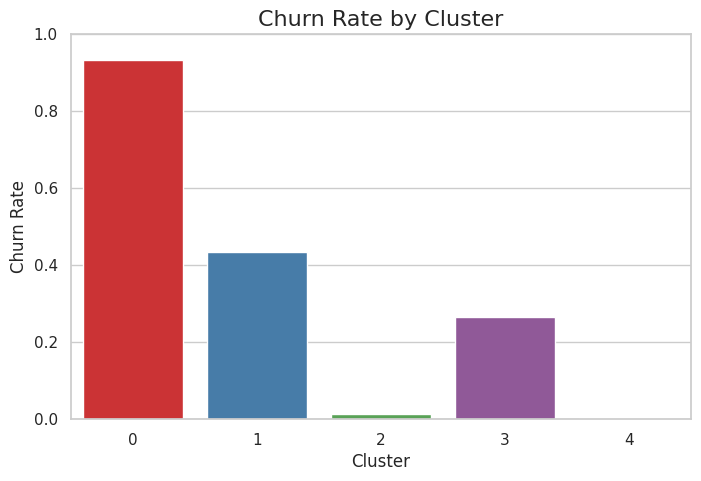

In [50]:
plt.figure(figsize=(8, 5))
sns.barplot(x=churn_rate.index, y=churn_rate['churn_rate'], palette='Set1')
plt.title('Churn Rate by Cluster', fontsize=16)
plt.ylabel('Churn Rate')
plt.xlabel('Cluster')
plt.ylim(0, 1)
plt.show()

### Detailed Interpretation of Churn Rates by Cluster

The table below summarizes the churn behavior for each cluster, including the number of churned and non-churned customers, the total number of customers in each cluster, and the churn rate for each cluster.

| Cluster | Churned | Non-Churned | Customers at Start | Churn Rate |
|---------|---------|-------------|--------------------|------------|
| **0**   | 715     | 52          | 767                | 93.22%     |
| **1**   | 224     | 293         | 517                | 43.33%     |
| **2**   | 15      | 1079        | 1094               | 1.37%      |
| **3**   | 103     | 283         | 386                | 26.68%     |
| **4**   | 4       | 1232        | 1236               | 0.32%      |

#### Cluster 0: **High Churn Risk Cluster (93.22% Churn Rate)**
- **Total Customers**: 767
- **Churned**: 715
- **Non-Churned**: 52
- **Churn Rate**: 93.22%

This cluster exhibits **extremely high churn rates**, with over **93% of customers leaving the gym**. This group likely contains the most disengaged customers, with a very short retention span. The gym might need to investigate the underlying reasons for such high churn in this group, such as dissatisfaction with the services, pricing, or overall experience. Targeting this group with retention strategies, like personalized offers or incentives, could be crucial to reducing churn.

#### Cluster 1: **Moderate Churn Risk Cluster (43.33% Churn Rate)**
- **Total Customers**: 517
- **Churned**: 224
- **Non-Churned**: 293
- **Churn Rate**: 43.33%

This cluster has a **moderate churn rate** of around **43%**, indicating that nearly half of the customers in this group have left the gym. The remaining half seems to be somewhat engaged, but there is room for improvement. The gym may want to focus on this group with engagement initiatives to ensure retention. For example, offering new classes, fitness challenges, or loyalty rewards could help retain customers in this cluster.

#### Cluster 2: **Loyal Customers Cluster (1.37% Churn Rate)**
- **Total Customers**: 1094
- **Churned**: 15
- **Non-Churned**: 1079
- **Churn Rate**: 1.37%

Cluster 2 is by far the **most loyal customer group** with an extremely low churn rate of **1.37%**. Out of 1094 customers in this group, only 15 have churned. This group likely represents the gym's **core, loyal customers** who are highly satisfied with the gym’s services and offerings. The gym should aim to **retain and reward these customers** to maintain this strong loyalty. This group could be leveraged for promoting referrals or providing testimonials to attract new members.

#### Cluster 3: **Low to Moderate Churn Risk Cluster (26.68% Churn Rate)**
- **Total Customers**: 386
- **Churned**: 103
- **Non-Churned**: 283
- **Churn Rate**: 26.68%

This cluster shows a **relatively low churn rate of 26.68%**, meaning that around one-quarter of the customers have left. While not as loyal as Cluster 2, the majority of customers in this group remain engaged. The gym can consider focusing retention efforts on the customers who have stayed by offering personalized experiences, longer-term contracts, or community-building activities to further lower churn rates in this group.

#### Cluster 4: **Extremely Loyal Cluster (0.32% Churn Rate)**
- **Total Customers**: 1236
- **Churned**: 4
- **Non-Churned**: 1232
- **Churn Rate**: 0.32%

Cluster 4 has an **exceptionally low churn rate of just 0.32%**, meaning only 4 out of 1236 customers have left the gym. This group represents the **most loyal customer base**, even more so than Cluster 2. These customers are extremely unlikely to churn, making them a valuable segment for long-term stability. The gym should continue to cultivate their loyalty through **VIP programs, exclusive classes, or premium services**. These customers are also excellent candidates for advocating for the gym in marketing efforts or referral programs.

### Overall Insights:

1. **High-Risk Clusters (Cluster 0)**: The churn rate in Cluster 0 is alarmingly high (93.22%). This cluster requires urgent attention and targeted interventions to prevent further churn. It's important to analyze this group deeply to understand the reasons behind such high churn and address them.

2. **Moderate-Risk Clusters (Cluster 1 and Cluster 3)**: These clusters have moderate churn rates (43.33% and 26.68%, respectively). They represent customers who are on the fence, and with the right strategies, the gym can prevent a significant portion of them from leaving. Targeted engagement and retention strategies, such as loyalty programs and personalized offers, would be beneficial here.

3. **Loyal Clusters (Cluster 2 and Cluster 4)**: These clusters are highly loyal, with churn rates of 1.37% and 0.32%. They are the backbone of the gym’s customer base. While they may not require immediate retention efforts, the gym should continue to invest in this segment through loyalty rewards, premium services, and community-building activities to maintain their loyalty.

### Recommendations:
- **Focus on Retention in Cluster 0**: Investigate why this cluster has such a high churn rate and take immediate action. Consider surveying this group for feedback on what could be improved or offering incentives to retain them.
- **Engagement for Cluster 1 and 3**: These clusters need more engagement to prevent churn. Introducing special offers, loyalty programs, or more personalized experiences could significantly reduce churn.
- **Maintain Loyalty in Cluster 2 and 4**: Continue rewarding and engaging these customers with premium services, loyalty perks, and opportunities for them to refer new customers. These clusters are the gym’s strongest advocates and are critical to long-term success.
